from: https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

In [1]:
import glob

In [2]:
# make dictionary of lists of names: {language: [... names ...]}

In [9]:
def find_files(path):
    return glob.glob(path)

data_glob = '/Users/kgraham/Downloads/practical-pytorch-master/data/names/*.txt'
print(find_files(data_glob))

['/Users/kgraham/Downloads/practical-pytorch-master/data/names/Arabic.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Chinese.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Czech.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Dutch.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/English.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/French.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/German.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Greek.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Irish.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Italian.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Japanese.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Korean.txt', '/Users/kgraham/Downloads/practical-pytorch-master/data/names/Polish.txt', '/Users/kgraham/Downloa

In [5]:
import unicodedata

In [8]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [10]:
# language to name dictionary
category_to_names = {}
categories = []

def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in find_files(data_glob):
    category = filename.split('/')[-1].split('.')[0]
    categories.append(category)
    
    names = read_lines(filename)
    category_to_names[category] = names
    
num_categories = len(categories)

In [11]:
print(category_to_names['English'][:2])

['Abbas', 'Abbey']


## Names to Tensors: one-hot encoding

A letter will be represented by a vector. The vector will have `N` dimensions, where `N` is the number of letters in the alphabet that makes up the names. In the "one-hot" encoding, only one element of the vector for a given letter will be 1, the rest will be zero. E.g. the letter `c` has the vector `<0 0 1 0 0 ...>`.

A word is then represented by the one-hot encodings for its letters. This gives a 2D matrix, of dimension word length by alphabet size. We will be training the neural net one word at a time. PyTorch assumes everything is in mini-batches, so we'll turn the 2D matrix into a tensor by adding one extra dimension. To be specific, a given letter will be a `1 x N` tensor, instead of just a vector.

In [12]:
import torch
import string

In [20]:
alphabet = string.ascii_letters + " .,;'"
# includes capital letters
alphabet_size = len(alphabet)

# get index of each letter in the alphabet
def letter_to_index(letter):
    return alphabet.find(letter)

# letter_to_index("a") = 0

# for example, get the one-hot encoding for a letter
def letter_to_tensor(letter):
    t = torch.zeros(1, alphabet_size)
    t[0][letter_to_index(letter)] = 1
    return t

def name_to_tensor(name):
    # one row for each letter, a single column, then the one-hot elements extend into the plane
    name_tensor = torch.zeros(len(name), 1, alphabet_size)
    for character_index, character in enumerate(name):
        name_tensor[character_index][0][letter_to_index(character)] = 1
    return name_tensor

In [21]:
letter_to_tensor("c")



Columns 0 to 12 
    0     0     1     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

In [23]:
name_to_tensor('Jones').size()

torch.Size([5, 1, 57])

## The network

In [24]:
import torch.nn as nn
from torch.autograd import Variable

In [26]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_layer = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.hidden_layer(combined)
        output = self.output_layer(combined)
        output = self.softmax(output)
        return output, hidden
    
    # used to initialize previous hidden state
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
num_hidden = 128
rnn = CharRNN(alphabet_size, num_hidden, num_categories)

In [27]:
input = Variable(letter_to_tensor('A'))
hidden = Variable(torch.zeros(1, num_hidden))

output, next_hidden = rnn(input, hidden)

In [29]:
# do one word at a time
input = Variable(name_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, num_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8879 -2.9799 -2.8156 -2.9147 -2.8622 -2.9545 -2.9520 -2.7910 -2.9511 -2.8313

Columns 10 to 17 
-2.9085 -3.0257 -2.8999 -2.9101 -2.8581 -2.7628 -2.8420 -2.9191
[torch.FloatTensor of size 1x18]



## Training data

In [39]:
import numpy as np
torch.from_numpy(np.array([1.0,2.0,3.0,4.02,5.3])).topk(1)


(
  5.3000
 [torch.DoubleTensor of size 1], 
  4
 [torch.LongTensor of size 1])

In [57]:
def output_to_category(output):
    top_scores, top_index = output.data.topk(1)
    index_of_best_category = top_index[0][0]
    return categories[index_of_best_category], index_of_best_category

print(output_to_category(output))

('Dutch', 3)


In [42]:
from random import randint

def get_random_element(vector):
    return vector[randint(0, len(vector) - 1)]

In [43]:
def random_training_pair():
    category = get_random_element(categories)
    name = get_random_element(category_to_names[category])
    category_tensor = Variable(torch.LongTensor([categories.index(category)]))
    name_tensor = Variable(name_to_tensor(name))
    return category, name, category_tensor, name_tensor

In [45]:
for i in range(10):
    category, name, category_tensor, name_tensor = random_training_pair()
    print('category: ', category, '| name: ', name)

category:  Vietnamese | name:  Lac
category:  Czech | name:  Skeril
category:  Spanish | name:  Azarola
category:  Scottish | name:  Jackson
category:  Greek | name:  Letsos
category:  Dutch | name:  Snaaijer
category:  Arabic | name:  Asfour
category:  German | name:  Kruger
category:  Korean | name:  Chang
category:  Scottish | name:  Gibson


Is picking training examples at random the best thing to do here? Don't we want to break the dataset up into train and test sets? If it were larger, we could do k-fold cross-validation.

## Training the neural network

In [46]:
# loss function here is negative log-liklihood
criterion = nn.NLLLoss() 

Training over mini-batches occurs in a loop with the following steps:
1. create input and target tensors
- initialize the hidden state to zero
- zero out the gradients
- read each letter in the name
    - keep hidden state for the next letter in the name
- compare final output to the target
- backprop
- return the output and loss

In [49]:
learning_rate = 0.005

# this treats each name as a mini-batch
def train(category_tensor, name_tensor):
    # name_tensor has dimension (num_letters in name) x 1 x alphabet_size
    
    # initialize the mini-batch
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    # loop over each letter in the name
    num_letters = name_tensor.size()[0]
    for i in range(num_letters):
        output, hidden = rnn(name_tensor[i], hidden)
        
    # compute loss and backpropagate
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # update parameters' gradients
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.data[0]

In [52]:
import time
import math

num_epochs = 100000
print_every = 5000
plot_every = 1000

rnn = CharRNN(alphabet_size, num_hidden, num_categories)

# track loss for plotting
current_loss = 0
losses = []

def time_since(t):
    now = time.time()
    seconds = now - t
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

start = time.time()

for epoch in range(1, num_epochs + 1):
    category, name, category_tensor, name_tensor = random_training_pair()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss
    
    # print progress
    if epoch % print_every == 0:
        prediction, prediction_index = output_to_category(output)
        correct = '🌟' if prediction == category else '💩 (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / num_epochs * 100, time_since(start), loss, name, prediction, correct))
        
    # store average losses
    if epoch % plot_every == 0:
        losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.4237 Kolen / Dutch 🌟
10000 10% (0m 10s) 2.6823 Halabi / Italian 💩 (Arabic)
15000 15% (0m 16s) 1.8467 Vargas / Portuguese 🌟
20000 20% (0m 22s) 1.9926 Diarmaid / Japanese 💩 (Irish)
25000 25% (0m 28s) 1.3129 Awdienko / Russian 🌟
30000 30% (0m 34s) 1.6529 Sokoloff / Russian 💩 (Polish)
35000 35% (0m 40s) 0.7884 Chai / Chinese 🌟
40000 40% (0m 46s) 1.1730 Kwak / Korean 🌟
45000 45% (0m 52s) 0.2060 Shalhoub / Arabic 🌟
50000 50% (0m 58s) 0.1627 Lawniczak / Polish 🌟
55000 55% (1m 4s) 0.8445 Allan / Scottish 🌟
60000 60% (1m 10s) 5.8501 Daal / Vietnamese 💩 (Dutch)
65000 65% (1m 16s) 0.2567 Ohmiya / Japanese 🌟
70000 70% (1m 22s) 0.2369 Toshitala / Japanese 🌟
75000 75% (1m 28s) 3.6088 Giles / Portuguese 💩 (French)
80000 80% (1m 34s) 0.4989 Mogilnichenko / Russian 🌟
85000 85% (1m 40s) 2.2476 Sander / Arabic 💩 (German)
90000 90% (1m 46s) 1.8996 Reid / French 💩 (Scottish)
95000 95% (1m 52s) 0.5312 Sfakianos / Greek 🌟
100000 100% (1m 58s) 2.7687 Vikhert / Dutch 💩 (Russian)


## Plotting the results

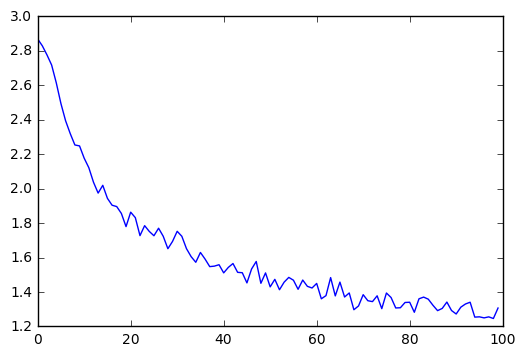

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses)

## Evaluating the results

Create a confusion matrix showing for each actual language (rows), which language the network predicts (columns). The predictions can be obtained by predicting for each name. This is the same loop as the training, except no backprop or loss functions. The predictions are made with the trained network. Ideally, the names used for training and the names used for predictions should be non-overlapping sets.

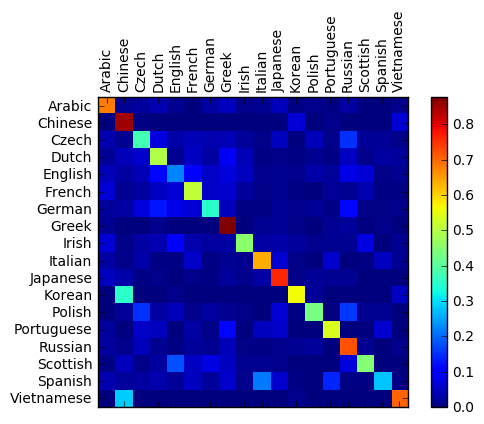

In [56]:
# there are about 20,000 names in the dataset, so we will look at half of them for the eval.

def predict(name_tensor):
    hidden = rnn.initHidden()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    return output

# generate confusion matrix
def generate_confusion_matrix(num_examples):
    confusion = torch.zeros(num_categories, num_categories)
    
    for i in range(num_examples):
        category, name, category_tensor, name_tensor = random_training_pair()
        output = predict(name_tensor)
        predicted_category, predicted_index = output_to_category(output)
        true_index = categories.index(category)
        confusion[true_index][predicted_index] += 1
        
    return confusion
    
def normalize_rows(confusion):
    for i in range(num_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    
    return confusion

confusion = normalize_rows(generate_confusion_matrix(10000))

# setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + categories, rotation=90)
ax.set_yticklabels([''] + categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

The model is good with Greek and pretty bad with English. It thinks Korean is Chinese and Vietnamese is Chinese.

# Testing the model on entirely new data

Now, we can give it other names and see how it does. 

In [61]:
def predict_top_3(name):
    print('\n', name)
    output = predict(Variable(name_to_tensor(name)))
    
    # get top 3 predictions
    top_scores, top_category_indices = output.data.topk(3, 1)
    
    predictions = []
    for i in range(3):
        score = top_scores[0][i]
        category_index = top_category_indices[0][i]
        print('\t(%.2f) %s' % (score, categories[category_index]))
        predictions.append([score, categories[category_index]])
        
#     print(predictions)

In [65]:
predict_top_3('Graham')
predict_top_3('Irueste')
predict_top_3('Hamilton')


 Graham
	(-1.20) Arabic
	(-1.45) Irish
	(-1.71) Scottish

 Irueste
	(-0.98) Scottish
	(-1.96) Greek
	(-2.15) French

 Hamilton
	(-0.70) Greek
	(-1.15) Russian
	(-2.85) French


In [66]:
predict_top_3('Lopez')
predict_top_3('Goldsmith')
predict_top_3('Putin')
predict_top_3('Carpenter')


 Lopez
	(-1.04) Spanish
	(-1.81) Czech
	(-1.96) Dutch

 Goldsmith
	(-1.09) Russian
	(-1.39) Scottish
	(-2.44) English

 Putin
	(-1.51) Russian
	(-2.03) French
	(-2.07) English

 Carpenter
	(-0.99) Dutch
	(-1.63) French
	(-1.98) English
